In [1]:
# Import all the necessary packages

import pandas as pd
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from fancyimpute import KNN
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, f1_score
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
!pip install catboost
from catboost import CatBoostClassifier

     |████████████████████████████████| 66.3MB 97kB/s 


In [3]:
# Loading the train data

df = pd.read_csv('train.csv')
df.head()

,customer_id,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1,customer_category
0,csid_1,13.168425,9.447662,-0.070203,-0.139541,0.436956,4.705761,2.537985,7.959503,C,F,0
1,csid_2,17.092979,7.329056,0.153298,-0.102726,0.380340,4.205138,4.193444,17.517381,C,A,0
2,csid_3,17.505334,5.143676,0.106709,0.262834,0.417648,4.479070,3.878971,12.595155,C,BA,0
3,csid_4,31.423381,4.917740,-0.020226,-0.100526,0.778130,5.055535,2.708940,4.795073,AA,F,0
4,csid_5,11.909502,4.237073,0.187178,0.172891,0.162067,3.445247,3.677360,56.636326,C,AA,0


In [4]:
# Getting to Know about the type of Data we have

print(df.shape)

# Checking whether the data is balanced or Imbalanced

print(df['customer_category'].unique())
print(df['customer_category'].value_counts())

df.info()

# Drop the Customer_ID column, as it doesnot help us in gaining insights 

df = df.drop(['customer_id'],axis = 1)

(10738, 12)
[0 1]
0    9443
1    1295
Name: customer_category, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10738 entries, 0 to 10737
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   customer_id                       10738 non-null  object 
 1   customer_visit_score              10738 non-null  float64
 2   customer_product_search_score     10696 non-null  float64
 3   customer_ctr_score                10738 non-null  float64
 4   customer_stay_score               10701 non-null  float64
 5   customer_frequency_score          10738 non-null  float64
 6   customer_product_variation_score  10692 non-null  float64
 7   customer_order_score              10672 non-null  float64
 8   customer_affinity_score           10738 non-null  float64
 9   customer_active_segment           10715 non-null  object 
 10  X1                                10701 non-null  obje

In [5]:
# Finding out about the missing values

print(df.isnull().sum())
print(df.isnull().sum().sum())

customer_visit_score                 0
customer_product_search_score       42
customer_ctr_score                   0
customer_stay_score                 37
customer_frequency_score             0
customer_product_variation_score    46
customer_order_score                66
customer_affinity_score              0
customer_active_segment             23
X1                                  37
customer_category                    0
dtype: int64
251


In [6]:
# check for Duplicated data

duplicate = df.duplicated()
print(duplicate.sum())

0


In [7]:
# check unique values of the categorical data

print(df['customer_active_segment'].unique())
print(df['X1'].unique())

# replacing the nan values in categorical attributes with mode 

df['customer_active_segment'] = df['customer_active_segment'].replace(np.nan, 
                                df['customer_active_segment'].mode().values[0])

df['X1'] = df['X1'].replace(np.nan, df['X1'].mode().values[0])

# check nan values again and replace the unique with numbers
print(df['X1'].isnull().sum())
print(df['customer_active_segment'].isnull().sum())

df['customer_active_segment'] = df['customer_active_segment'].map({'AA': 1,
                                'A': 0, 'B':2, 'C':4, 'D':5})

df['X1'] = df['X1'].map({'AA': 1, 'A': 0, 'BA':3, 'E':6, 'F':7})

['C' 'AA' 'B' 'A' 'D' nan]
['F' 'A' 'BA' 'AA' 'E' nan]
0
0


In [8]:
# Impute the missing values for the numerical columns

y = df['customer_category']
x = df.drop(['customer_category'], axis = 1)

scaler = MinMaxScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns = x.columns)
x.head()

imputer = KNN()
x = pd.DataFrame(imputer.fit_transform(x),columns = x.columns)
x.head()

Imputing row 1/10738 with 0 missing, elapsed time: 20.649
Imputing row 101/10738 with 0 missing, elapsed time: 20.651
Imputing row 201/10738 with 0 missing, elapsed time: 20.653
Imputing row 301/10738 with 0 missing, elapsed time: 20.653
Imputing row 401/10738 with 0 missing, elapsed time: 20.655
Imputing row 501/10738 with 0 missing, elapsed time: 20.656
Imputing row 601/10738 with 0 missing, elapsed time: 20.658
Imputing row 701/10738 with 0 missing, elapsed time: 20.659
Imputing row 801/10738 with 0 missing, elapsed time: 20.661
Imputing row 901/10738 with 0 missing, elapsed time: 20.663
Imputing row 1001/10738 with 0 missing, elapsed time: 20.664
Imputing row 1101/10738 with 0 missing, elapsed time: 20.665
Imputing row 1201/10738 with 0 missing, elapsed time: 20.667
Imputing row 1301/10738 with 0 missing, elapsed time: 20.669
Imputing row 1401/10738 with 0 missing, elapsed time: 20.670
Imputing row 1501/10738 with 0 missing, elapsed time: 20.670
Imputing row 1601/10738 with 0 missi

,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1
0,0.269578,0.571994,0.148038,0.021297,0.007799,0.122126,0.249190,0.033916,0.8,1.000000
1,0.353548,0.445888,0.217287,0.023724,0.006717,0.090820,0.438887,0.072295,0.8,0.000000
2,0.362370,0.315807,0.202852,0.047831,0.007430,0.107950,0.402852,0.052530,0.8,0.428571
3,0.660161,0.302359,0.163523,0.023870,0.014314,0.144000,0.268779,0.021209,0.2,1.000000
4,0.242642,0.261843,0.227785,0.041900,0.002549,0.043300,0.379749,0.229374,0.8,0.142857


In [9]:
print(x.isnull().sum().sum())

0


<function matplotlib.pyplot.show>

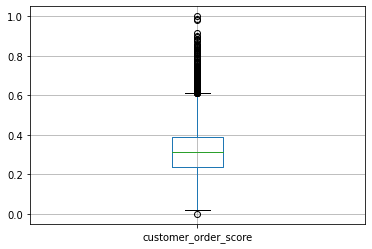

In [10]:
# Plot a Boxplot for a attribute to see outliers

x.boxplot(column=['customer_order_score'])
plt.show

customer_visit_score                0.235007
customer_product_search_score       0.151134
customer_ctr_score                  0.046094
customer_stay_score                 0.013622
customer_frequency_score            0.015502
customer_product_variation_score    0.130787
customer_order_score                0.148968
customer_affinity_score             0.074625
customer_active_segment             0.400000
X1                                  0.285714
dtype: float64


<function matplotlib.pyplot.show>

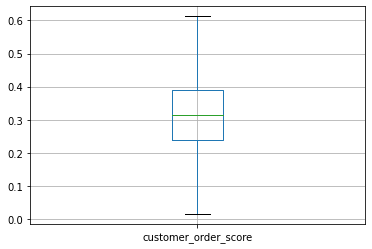

In [11]:
# Replace outliers with IQR for only numerical columns 

Q1 = x.quantile(0.25)
Q3 = x.quantile(0.75)
IQR = Q3 - Q1
print(IQR)


def outlier(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    low_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return low_range, upper_range

for i in IQR.keys():
    low, upper = outlier(x[i])
    x[i] = np.where(x[i] > upper, upper, x[i])
    x[i] = np.where(x[i] < low, low, x[i])
    

# check for outliers again using Boxplot 
x.boxplot(column=['customer_order_score'])
plt.show            

## Data Visualization For gaining Insights

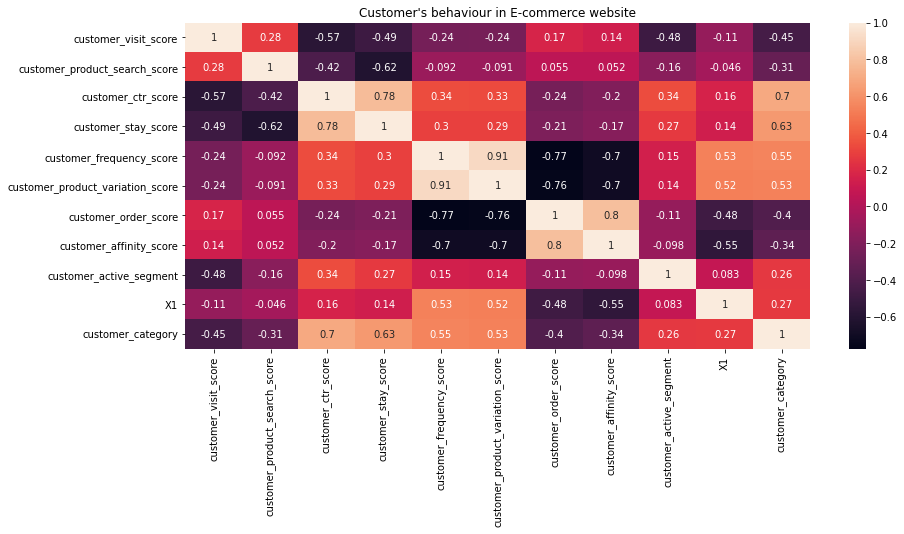

In [12]:
# Set the width and height of the figure
plt.figure(figsize=(14,6))

# Add title
plt.title("Customer's behaviour in E-commerce website")

df1 = pd.concat([x,y], axis = 1)

# Plot the correlation Heatmap using Seaborn 
cor = df1.corr()
sns.heatmap(data=cor, annot=True)

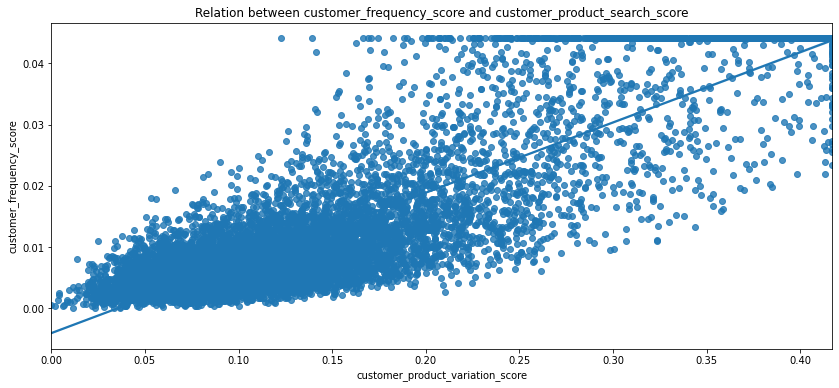

In [13]:
'''
As per above correlation heatmap, we can see that customer_frequency_score and 
customer_product_variation_score are perfectly correlated with each other 
'''
# Plot a ScatterPlot to visualize customer_frequency_score and customer_product_variation_score

plt.figure(figsize=(14,6))

plt.title('Relation between customer_frequency_score and customer_product_search_score')

sns.regplot(y =df1['customer_frequency_score'],x=df1['customer_product_variation_score'])
                #hue = df1['customer_category'])

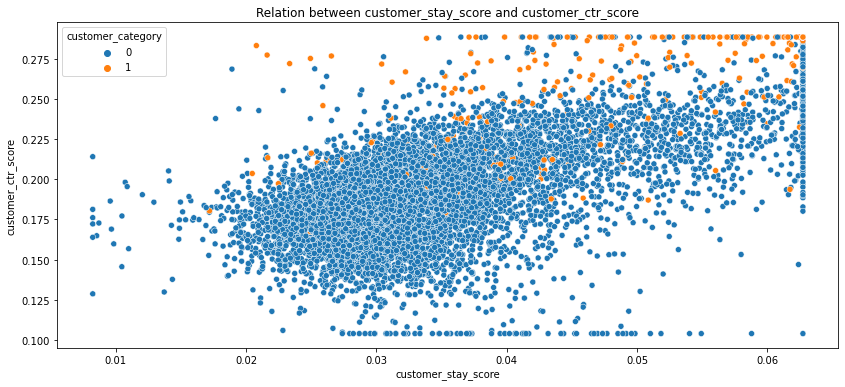

In [14]:
'''
As per above correlation heatmap, we can see that customer_stay_score and 
customer_ctr_score are strongly correlated with each other 
'''
# Plot a ScatterPlot to visualize customer_stay_score and customer_ctr_score

plt.figure(figsize=(14,6))

plt.title('Relation between customer_stay_score and customer_ctr_score')

sns.scatterplot(x =df1['customer_stay_score'], y=df1['customer_ctr_score'],
                hue = df1['customer_category'])

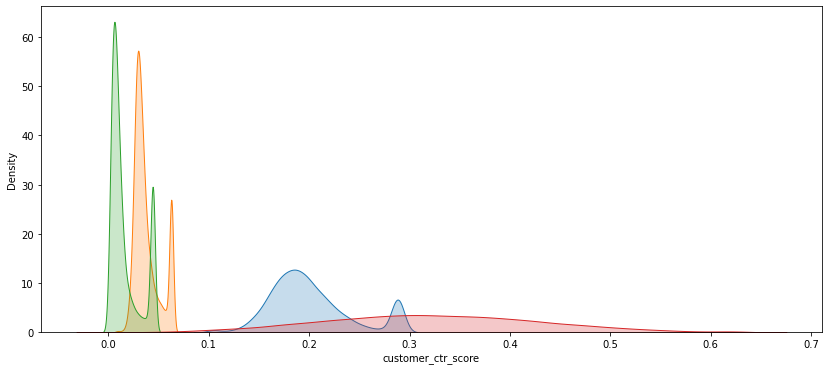

In [15]:
# Let us check the distibutions of each columns using KDEplot 

plt.figure(figsize=(14,6))

sns.kdeplot(data = df1['customer_ctr_score'], 
            shade = True)

sns.kdeplot(data = df1['customer_stay_score'], 
            shade = True)

sns.kdeplot(data = df1['customer_frequency_score'], 
            shade = True)

sns.kdeplot(data = df1['customer_product_search_score'], shade = True)

## As Per the above graph, we can see that each column plotted is Normally Distributed. 

In [ ]:
cat = CatBoostClassifier()
params = {'iterations': [500],
          'learning_rate': [0.01,0.02,0.05,0.1],
          'depth': [3,4, 5, 6],
          'loss_function': ['Logloss', 'CrossEntropy'],
          'l2_leaf_reg': np.logspace(-20, -19, 3),
          'leaf_estimation_iterations': [10],
          'logging_level':['Silent'],
          'random_seed': [42]
         }
clf = GridSearchCV(estimator=cat, param_grid=params, scoring = 'precision', cv=10)
clf.fit(x, y)

print(clf.best_params_)

{'depth': 5, 'iterations': 500, 'l2_leaf_reg': 1e-19, 'leaf_estimation_iterations': 10, 'learning_rate': 0.02, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}


In [ ]:
params = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }
lg = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary',
                                   num_boost_round=2000, learning_rate=0.01, metric='roc')
lgb = GridSearchCV(estimator=lg, param_grid=params, scoring = 'precision', cv=10) 

lgb.fit(x,y)

print(lgb.best_params_)

{'lambda_l1': 1.5, 'lambda_l2': 0, 'min_data_in_leaf': 100, 'num_leaves': 127, 'reg_alpha': 0.1}


In [ ]:
params = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000],
          'tol': [1e-2,1e-3, 1e-4, 1e-5, 1e-7,1e-9]}
lg = LogisticRegression()
lr = GridSearchCV(estimator=lg, param_grid=params, scoring = 'precision', cv=10)
lr.fit(x, y)

print(lr.best_params_)

{'C': 0.1, 'penalty': 'l2', 'tol': 0.01}


In [ ]:
param_grid = { 
    'n_estimators': [100, 200,500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=42)
rfc = GridSearchCV(estimator=rf, param_grid=param_grid, scoring = 'precision' ,cv= 10)
rfc.fit(x, y)

print(rfc.best_params_)

{'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 200}


In [16]:
test = pd.read_csv('test.csv')
test.head()

,customer_id,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1
0,csid_10739,22.500174,3.702145,0.118811,0.093253,0.689237,5.786842,3.748009,7.661716,B,BA
1,csid_10740,13.225950,3.600102,0.130985,0.053575,0.142756,3.940359,3.469659,33.999679,B,AA
2,csid_10741,14.603376,5.084047,-0.004651,-0.036299,0.333709,4.254662,3.855939,33.485630,B,AA
3,csid_10742,26.149905,3.025501,0.229740,0.204591,3.768405,6.942625,2.362421,0.795372,B,BA
4,csid_10743,19.810630,5.020400,-0.011347,-0.028780,0.286841,4.585513,3.278624,15.052058,C,BA


In [17]:
print(test.isnull().sum())
test.isnull().sum().sum()

customer_id                          0
customer_visit_score                 0
customer_product_search_score       29
customer_ctr_score                   0
customer_stay_score                 16
customer_frequency_score             0
customer_product_variation_score    43
customer_order_score                41
customer_affinity_score              0
customer_active_segment             12
X1                                  25
dtype: int64


166

In [18]:
# replacing the nan values in categorical attributes with mode 

test['customer_active_segment'] = test['customer_active_segment'].replace(np.nan, 
                                test['customer_active_segment'].mode().values[0])

test['X1'] = test['X1'].replace(np.nan, test['X1'].mode().values[0])

# check nan values again and replace the unique with numbers
print(test['X1'].isnull().sum())
print(test['customer_active_segment'].isnull().sum())

test['customer_active_segment'] = test['customer_active_segment'].map({'AA': 1,
                                'A': 0, 'B':2, 'C':4, 'D':5})

test['X1'] = test['X1'].map({'AA': 1, 'A': 0, 'BA':3, 'E':6, 'F':7})

0
0


In [19]:
sub = test['customer_id']
test = test.drop(['customer_id'], axis = 1)

scaler = MinMaxScaler()
test = pd.DataFrame(scaler.fit_transform(test), columns = test.columns)
test.head()

imputer = KNN()
test = pd.DataFrame(imputer.fit_transform(test),columns = test.columns)
test.head()

Imputing row 1/7160 with 0 missing, elapsed time: 8.849
Imputing row 101/7160 with 0 missing, elapsed time: 8.850
Imputing row 201/7160 with 0 missing, elapsed time: 8.851
Imputing row 301/7160 with 0 missing, elapsed time: 8.851
Imputing row 401/7160 with 0 missing, elapsed time: 8.852
Imputing row 501/7160 with 0 missing, elapsed time: 8.854
Imputing row 601/7160 with 0 missing, elapsed time: 8.855
Imputing row 701/7160 with 0 missing, elapsed time: 8.856
Imputing row 801/7160 with 0 missing, elapsed time: 8.857
Imputing row 901/7160 with 0 missing, elapsed time: 8.857
Imputing row 1001/7160 with 0 missing, elapsed time: 8.859
Imputing row 1101/7160 with 0 missing, elapsed time: 8.860
Imputing row 1201/7160 with 0 missing, elapsed time: 8.862
Imputing row 1301/7160 with 0 missing, elapsed time: 8.863
Imputing row 1401/7160 with 0 missing, elapsed time: 8.864
Imputing row 1501/7160 with 0 missing, elapsed time: 8.864
Imputing row 1601/7160 with 0 missing, elapsed time: 8.865
Imputing 

,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1
0,0.509487,0.276679,0.233464,0.034142,0.013417,0.187338,0.290421,0.031670,0.4,0.428571
1,0.287148,0.269281,0.237337,0.031291,0.002412,0.074589,0.264570,0.133853,0.4,0.142857
2,0.320171,0.376876,0.194191,0.024832,0.006257,0.093781,0.300445,0.131858,0.4,0.142857
3,0.596985,0.227618,0.268750,0.042143,0.075421,0.257911,0.161737,0.005030,0.4,0.428571
4,0.445008,0.372261,0.192061,0.025372,0.005314,0.113983,0.246828,0.060342,0.8,0.428571


customer_visit_score                0.251884
customer_product_search_score       0.175699
customer_ctr_score                  0.041365
customer_stay_score                 0.011742
customer_frequency_score            0.010886
customer_product_variation_score    0.095642
customer_order_score                0.114214
customer_affinity_score             0.074462
customer_active_segment             0.400000
X1                                  0.285714
dtype: float64


<function matplotlib.pyplot.show>

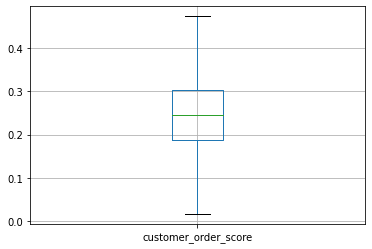

In [20]:
# Replace outliers with IQR for only numerical columns 

Q1 = test.quantile(0.25)
Q3 = test.quantile(0.75)
IQR = Q3 - Q1
print(IQR)


def outlier(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    low_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return low_range, upper_range

for i in IQR.keys():
    low, upper = outlier(test[i])
    test[i] = np.where(test[i] > upper, upper, test[i])
    test[i] = np.where(test[i] < low, low, test[i])
    

# check for outliers again using Boxplot 
test.boxplot(column=['customer_order_score'])
plt.show            

## As the training data given is imbalanced data, Let us use StratifiedKFold cross validation for predicting our test set 

In [23]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lst_accu_stratified = [] 
full_test = 0

clf = CatBoostClassifier(depth = 5, iterations = 500, l2_leaf_reg = 1e-19, 
                         leaf_estimation_iterations = 10, learning_rate = 0.02,
                         logging_level = 'Silent', loss_function = 'Logloss', 
                         random_seed = 42)

lgb = LGBMClassifier(boosting_type='gbdt',  objective='binary',
                          num_boost_round=2000, learning_rate=0.01, metric='roc',
                         lambda_l1 = 1.5, lambda_l2 =0, min_data_in_leaf = 100,
                         num_leaves = 127, reg_alpha = 0.1)

lr = LogisticRegression(C = 0.1, penalty = 'l2', tol = 0.01)
rfc = RandomForestClassifier(random_state=42, criterion = 'gini', max_depth = 3,
                             max_features = 'auto', n_estimators = 200)

enclf = VotingClassifier(estimators = [('lgb',lgb), ('cat', clf), ('lgr',lr),
                                       ('rfc',rfc)])

for train_index, test_index in skf.split(x, y):
    X_train, X_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    enclf.fit(X_train, y_train) 
    lst_accu_stratified.append(f1_score(y_test, enclf.predict(X_test)))

    tpred = enclf.predict(test)
    full_test = full_test + tpred


full_test = full_test / 10

for i in range(len(full_test)):
    if full_test[i]>0.5:
        full_test[i] = 1
    else:
        full_test[i] = 0

print('List of possible precision:', lst_accu_stratified) 
print('\nMaximum precision That can be obtained from this model is:', 
      max(lst_accu_stratified)*100, '%') 
print('\nMinimum precision:', min(lst_accu_stratified)*100, '%')  

List of possible precision: [0.8523206751054851, 0.8833333333333332, 0.8776371308016877, 0.894308943089431, 0.8786610878661087, 0.8547008547008548, 0.894308943089431, 0.8906882591093118, 0.884297520661157, 0.9230769230769232]

Maximum precision That can be obtained from this model is: 92.30769230769232 %

Minimum precision: 85.23206751054852 %


In [24]:
full_test = full_test.tolist()
print(full_test.count(0))
print(full_test.count(1))

6817
343


In [25]:
sub = pd.DataFrame(sub,columns = ['customer_id'])
sub['customer_category'] = tpred
sub.head()

,customer_id,customer_category
0,csid_10739,0
1,csid_10740,0
2,csid_10741,0
3,csid_10742,0
4,csid_10743,0


In [26]:
sub.to_csv('sub.csv', index=False)